# Source

**Paper:** https://arxiv.org/abs/1908.06954

**Code:** https://github.com/husthuaan/AoANet

# References

*   CSC413 Assignements and Lecture Notes, https://uoft-csc413.github.io/2023/, There was a lot of inspiration taken from the assignments
*   Attention on Attention for Image Captioning, https://arxiv.org/abs/1908.06954, The model explained on the paper was reimplemented
*   AoANet, by husthuaan (Lun Huang), https://github.com/husthuaan/AoANet, The AoA Net model is in this notebook was heavily inspired by the original implementaion of AoA Net
*   Self-critical Sequence Training for Image Captioning, https://arxiv.org/abs/1612.00563, SCST was used for this model
*   Show, Attend and Tell: Neural Image Caption Generation with Visual Attention, https://arxiv.org/abs/1502.03044, The Show, Attend and Tell model was used as part of SCST and this model
*   ImageCaptioning.pytorch, by ruotianluo (Ruotian Luo), https://github.com/ruotianluo/ImageCaptioning.pytorch, The code from 'Show, Attend, and Tell' and SCST was used from here




# Loading Data

## Helper Functions and Imports

In [ ]:
%matplotlib inline

from typing import Callable, Optional
from collections import defaultdict

import os
import urllib
import zipfile
import tarfile

from PIL import Image

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.dropout import Dropout
import torchvision
from torchvision.transforms import transforms
import torch.utils.data as torch_data

if torch.cuda.is_available():
    torch.cuda.set_device('cuda:0') # if available

!pip install pycocoevalcap
!pip install pycocotools

from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ROOT_DATA_DIR = '/content/eta_data'

In [ ]:
# create directories
os.makedirs(f'{ROOT_DATA_DIR}/raw', exist_ok=True)

In [ ]:
def preprocess_caption(caption: str) -> str:
  """Preprocess a caption.
  """
  return caption.strip().lower().split()

def preprocess_captions(captions: list[str]) -> list[str]:
  """Preprocess multiple captions.
  """
  return list(map(preprocess_caption, captions))

## Choose Dataset (Not All Datasets are Fully Supported)

Due to memory constraints when working with the data and model Flickr30K and MSCOCO are untested and unsupported.

### Flickr8K (Supported)

In [ ]:
URLS = [
    'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
    'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Text.zip'
]
NAMES = [
  'flickr8k_images',
  'flickr8k_annotations'
]

# download and extract zips
for url, name in zip(URLS, NAMES):
  urllib.request.urlretrieve(url, f'{ROOT_DATA_DIR}/raw/{name}.zip')

  with zipfile.ZipFile(f'{ROOT_DATA_DIR}/raw/{name}.zip', mode='r') as z:
    z.extractall(f'{ROOT_DATA_DIR}/{name}')

In [ ]:
class Flikr8kDataset(torchvision.datasets.VisionDataset):

  image_dir: str

  image_names: list[str]
  captions: dict[str, list[str]]

  transforms: Optional[Callable]

  def __init__(self, root: str, captions: str, subset: Optional[str] = None,
               transforms: Optional[Callable] = None, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
    """Load Flickr8k data.

    :param root: Parent directory of image files.
    :param captions: File path to a file containing captions for images. Every line should 
                     have the format: "<image path in image_dir>#<caption index> <caption>".
    :param subset: File path to a file with a subset of images to load. Every line
                   should have the format: "<image path in image_dir>".
    :param transforms: A function/transforms that takes in an image and a label and returns the transformed versions of both.
    :param transform: A function/transform that takes in an PIL image and returns a transformed version.
    :param target_transform: A function/transform that takes in the target and transforms it.

    .. note::
        ``transforms`` and the combination of ``transform`` and ``target_transform`` are mutually exclusive.
    .. seealso:: https://pytorch.org/vision/stable/datasets.html
    """
    super().__init__(root)

    self.image_dir = root

    # setup transformations
    if transforms and (transform or target_transform):
      raise ValueError('Cannot specify both `transforms` and either of `transform` or `target_transform`')
    if transforms:
      self.transforms = transforms
    else:
      transform = transform if transform else lambda image: image
      target_transform = target_transform if target_transform else lambda target: target
      self.transforms = lambda image, targets: (transform(image), target_transform(targets))

    # setup valid images
    if subset is None:
      _, _, self.image_names = next(os.walk(root))
    else:
      with open(subset, mode='r') as f:
        self.image_names = f.read().strip().split('\n')

    # process captions
    self.captions = defaultdict(list)
    with open(captions, mode='r') as f:
      for line in f:
        line = line.strip()
        if len(line) > 0:
          name, rest = line.split('#', maxsplit=1)
          _, caption = rest.split(maxsplit=1)
          if name in self.image_names:
              self.captions[name].append(caption.strip())

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, key):
    image_name = self.image_names[key]

    image = Image.open(os.path.join(self.image_dir, image_name))
    image.load()
    captions = self.captions[image_name]
    return self.transforms(image, captions)


#### Choose Data Split (Choose Data Split)

In [ ]:
flickr8k_data = Flikr8kDataset(f'{ROOT_DATA_DIR}/flickr8k_images/Flicker8k_Dataset',
                              f'{ROOT_DATA_DIR}/flickr8k_annotations/Flickr8k.lemma.token.txt',
                               target_transform=preprocess_captions)

# flickr8k_data = Flikr8kDataset(f'{ROOT_DATA_DIR}/flickr8k_images/Flicker8k_Dataset',
#                               f'{ROOT_DATA_DIR}/flickr8k_annotations/Flickr8k.lemma.token.txt',
#                                subset=f'{ROOT_DATA_DIR}/flickr8k_annotations/Flickr_8k.testImages.txt',
#                                target_transform=preprocess_captions)


# We had to run
# train_indices, val_indices, test_indices, extra = torch_data.random_split(range(len(flickr8k_data)), [0.1, 0.2, 0.2, 0.5], torch.Generator())

train_indices, val_indices, test_indices = torch_data.random_split(range(len(flickr8k_data)), [0.8, 0.1, 0.1], torch.Generator())
train_indices, val_indices, test_indices = list(train_indices), list(val_indices), list(test_indices)

### Flickr30K (Not Supported)

In [ ]:
# URLS = [
#     'https://uofi.app.box.com/shared/static/1cpolrtkckn4hxr1zhmfg0ln9veo6jpl',
#     'http://shannon.cs.illinois.edu/DenotationGraph/data/flickr30k.tar.gz'
# ]
# NAMES = [
#   'flickr30k_images',
#   'flickr30k_annotations'
# ]

# # download and extract zips
# for url, name in zip(URLS, NAMES):
#   urllib.request.urlretrieve(url, f'{ROOT_DATA_DIR}/raw/{name}.tar.gz')

#   with tarfile.open(f'{ROOT_DATA_DIR}/raw/{name}.tar.gz', mode='r') as z:
#     z.extractall(f'{ROOT_DATA_DIR}/{name}')

### MSCOCO (Not Supported)

In [ ]:
# IMAGES = [
#   'coco_val2014',
#   'coco_train2014'
# ]
# # download images (gsutil rsync method is not working, need to use the slower method)
# BASE_URL = 'http://images.cocodataset.org/zips'
# for name in IMAGES:
#   urllib.request.urlretrieve(f'{BASE_URL}/{name.split("_")[1]}.zip', f'{ROOT_DATA_DIR}/raw/{name}.zip')

#   with zipfile.ZipFile(f'{ROOT_DATA_DIR}/raw/{name}.zip', mode='r') as z:
#     z.extractall(f'{ROOT_DATA_DIR}/{name}')

In [ ]:
# ANNOTATIONS = [
#   'annotations_trainval2014'
# ]

# for name in IMAGES:
#   os.makedirs(f'{ROOT_DATA_DIR}/{name}', exist_ok=True)

# # download annotations
# BASE_URL = 'http://images.cocodataset.org/annotations'
# for name in ANNOTATIONS:
#   urllib.request.urlretrieve(f'{BASE_URL}/{name}.zip', f'{ROOT_DATA_DIR}/raw/{name}.zip')

#   with zipfile.ZipFile(f'{ROOT_DATA_DIR}/raw/{name}.zip', mode='r') as z:
#     z.extractall(f'{ROOT_DATA_DIR}/coco_annotations/{name.split("_")[1]}')

# Model

## MultiHead Attention


In [ ]:
class ScaledDotAttention(nn.Module):
    """
    Scaled Dot Attention without weights
    """
    def __init__(self, hidden_size, dropout = 0):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.softmax = nn.Softmax(dim=-1)
        self.scaling_factor = torch.rsqrt(
            torch.tensor(self.hidden_size, dtype=torch.float, requires_grad=True)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask = None):
        batch_size = queries.shape[0]
        q = queries
        if (queries.dim() == 2):
            q = q.unsqueeze(1)
        
        unnormalized_attention = torch.matmul(q, keys.transpose(-2, -1)) * self.scaling_factor

        if mask is not None:
            masked_unnorm = unnormalized_attention.masked_fill(mask==0, -1e7)

        attention_weights = self.softmax(unnormalized_attention)

        dropped_attention = self.dropout(attention_weights)

        context = torch.matmul(attention_weights, values)
        return context, attention_weights

In [ ]:
class MultiHeadAtt(nn.Module):
    """
    Multihead Attention without weights using the scaled dot attention
    @param n_features: the hidden size
    """
    def __init__(self, n_features: int, n_heads: int, dropout: float = 0.1):
        super(MultiHeadAtt, self).__init__()

        self.n_heads = n_heads

        assert n_features % n_heads == 0
        self.n_hidden = n_features // n_heads

        self.out_features = n_features

        self.attention = ScaledDotAttention(self.n_hidden, dropout)


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask = None, b: bool=False):
        if mask is not None:
          mask = mask.unsqueeze(1)

        single_query = False
        if len(query.size()) == 2:
            single_query = True
            query = query.unsqueeze(1)

        n_nodes = query.shape[0]

        q = query.view(n_nodes, -1, self.n_heads, self.n_hidden).transpose(1, 2)
        k = key.view(n_nodes, -1, self.n_heads, self.n_hidden).transpose(1, 2)
        v = value.view(n_nodes, -1, self.n_heads, self.n_hidden).transpose(1, 2)

        att, weights = self.attention(q, k, v, mask)

        res = att.transpose(1, 2).contiguous().view(n_nodes, -1, self.n_heads * self.n_hidden)

        if single_query:
            res = res.squeeze(1)

        return res
        

## AoA Module

Section 3.1

In [ ]:
class AoA(nn.Module):
    """
    AoA module from Attention on Attention Document
    @param hidden_size: the dimension of the vectors
    """
    def __init__(self, hidden_size: int, dropout: float = 0.3):
        super(AoA, self).__init__()

        # sequence for producing g
        self.prod_g = nn.Sequential(nn.Linear(2 * hidden_size, hidden_size), nn.Sigmoid())

        # sequence for producing i
        self.prod_i = nn.Linear(2 * hidden_size, hidden_size)

        # Dropout
        self.dropout = nn.Dropout(dropout)


    def forward(self, a: torch.tensor, q: torch.tensor, dim: int=-1):
        # Concat a and q
        con = torch.cat((a, q), dim=dim)
        con_drop = self.dropout(con)
        
        # g = sigmoid(W*con)
        g = self.prod_g(con)

        # i = W*con
        i = self.prod_i(con)

        # result = g * i (elementswise multiplication)
        result = g * i
            
        return result


## AoA Refiner/Encoder

Section 3.2.1

In [ ]:
class AoAEncoderLayer(nn.Module):
    def __init__(self, n_features: int, n_heads: int, att_dropout=0.1, aoa_dropout=0.3):
        """
        A single AoA Encoder layer from Attention on Attention Document
        @param n_features: the dimension of the vectors
        @param n_heads: the number of heads for attention
        @param att_dropout: the dropout for attention
        @param aoa_dropout: the dropout for aoa module
        """
        super(AoAEncoderLayer, self).__init__()

        self.n_heads = n_heads
        self.hidden = n_features

        self.prod_q = nn.Linear(n_features, n_features)
        self.prod_k = nn.Linear(n_features, n_features)
        self.prod_v = nn.Linear(n_features, n_features)

        self.attention = MultiHeadAtt(n_features, n_heads, att_dropout)

        self.AoA = AoA(n_features, aoa_dropout)

        self.layer_norm = nn.LayerNorm(n_features)

        self.dropout = nn.Dropout(att_dropout)


    def forward(self, a, mask = None):
        # apply linear transformation to attention 3 times to obtain query, keys, and values
        q = self.prod_q(a)
        k = self.prod_k(a)
        v = self.prod_v(a)

        # Find attention
        a2 = self.attention(q, k, v, mask)

        # Use aoa module
        aoa_res = self.AoA(a2, q)

        # add old and new attention (similar to skip layer)
        new_a = a + a2

        return self.layer_norm(new_a)

In [ ]:
class AoAEncoder(nn.Module):

    def __init__(self, n_features: int, n_heads: int, att_dropout=0.1, aoa_dropout=0.3, n_layers:int=6):
        """
        AoA Encoder from Attention on Attention Document combining encoder layers
        @param n_features: the dimension of the vectors
        @param n_heads: the number of heads for attention
        @param att_dropout: the dropout for attention
        @param aoa_dropout: the dropout for aoa module
        @param n_layers: the number of encoder layers
        """
        super(AoAEncoder, self).__init__()

        self.n_layers = n_layers
        self.layers = nn.ModuleList([AoAEncoderLayer(n_features, n_heads, att_dropout, aoa_dropout) for i in range(n_layers)])
        self.layer_norm = nn.LayerNorm(n_features)


    def forward(self, a, mask = None):
        # apply encoder layers
        for i in range(self.n_layers):
          a = self.layers[i](a, mask)
          
        # return the layer norm
        return self.layer_norm(a)

## AoA Decoder

Section 3.2.2

In [ ]:
class AoADecoder(nn.Module):

    def __init__(self, embedding_size: int, n_features: int, n_heads: int, att_dropout=0.1, dropout: int = 0.5):
        """
        AoA Decoder from Attention on Attention Document
        @param embedding_size: the embedding dimension of the words
        @param n_features: the dimension of the vectors
        @param n_heads: the number of heads for attention
        @param att_dropout: the dropout for attention
        @param dropout: decoder dropout
        """
        super(AoADecoder, self).__init__()

        self.n_heads = n_heads
        self.hidden_size = n_features

        # LTSM that takes word embedding concatenated with context vector
        self.lstm = nn.LSTMCell(embedding_size + n_features, n_features)

        # AoA module
        self.AoA = AoA(n_features)

        # Prepare queries
        self.q_prep = nn.Sequential(nn.LayerNorm(n_features), nn.Linear(n_features, n_features))

        # Multiheaded attention
        self.attention = MultiHeadAtt(n_features, n_heads)

        # dropout for context vectors
        self.context_drop = nn.Dropout(dropout)

        # output dropout
        self.dropout = nn.Dropout(dropout)


    def forward(self, word_emb, mean_feat, feat_vect, p_feat_vect: torch.tensor, state, att_masks=None):
        """
        @param word_emb: word embeddings
        @param mean_feat: mean of the features bar(a) in the document
        @param feat_vect: feature vectors, which are unused but required to work with other models
        @param p_feat_vect: previous feature vectors
        @param state:  state[0][0] is the initial hidden state
                        state[0][1] is the initial cell state
                        state[1][0] is the context vector from the previous layer
        """
        # get old hidden state and context vector
        h0, c0 = state[0][0], state[0][1]

        # LTSM cell
        input = torch.cat((word_emb, mean_feat + self.context_drop(state[1][0])), 1)

        # new hidden state and context vector
        h, c = self.lstm(input, (h0, c0))

        # Get attention
        A1 = p_feat_vect.narrow(2, 0, self.hidden_size)
        A2 = p_feat_vect.narrow(2, self.hidden_size, self.hidden_size)
        att = self.attention(h, A1, A2, att_masks, True)

        # AoA module
        aoa_res = self.AoA(att, h, dim=-1)

        # save data
        new_state = (torch.stack((h, c)), torch.stack((aoa_res, state[1][1])))

        # dropout
        output = self.dropout(aoa_res)
        return output, state

## AoA Model

### Show, Attend, and Tell and AllImg Code

Code is found here, https://github.com/husthuaan/AoANet/blob/master/models/CaptionModel.py

The code was formatted to work with the rest of the code

In [ ]:
# Input: seq, N*D numpy array, with element 0 .. vocab_size. 0 is END token.
def decode_sequence(ix_to_word, seq):
    N, D = seq.size()
    out = []
    for i in range(N):
        txt = ''
        for j in range(D):
            ix = seq[i,j]
            if ix > 0 :
                if j >= 1:
                    txt = txt + ' '
                txt = txt + ix_to_word[int(ix.item())]
            else:
                break
        if int(os.getenv('REMOVE_BAD_ENDINGS', '0')):
            flag = 0
            words = txt.split(' ')
            for j in range(len(words)):
                if words[-j-1] not in bad_endings:
                    flag = -j
                    break
            txt = ' '.join(words[0:len(words)+flag])
        out.append(txt.replace('@@ ', ''))
    return out


def penalty_builder(penalty_config):
    if penalty_config == '':
        return lambda x,y: y
    pen_type, alpha = penalty_config.split('_')
    alpha = float(alpha)
    if pen_type == 'wu':
        return lambda x,y: length_wu(x,y,alpha)
    if pen_type == 'avg':
        return lambda x,y: length_average(x,y,alpha)


def length_wu(length, logprobs, alpha=0.):
    """
    NMT length re-ranking score from
    "Google's Neural Machine Translation System" :cite:`wu2016google`.
    """

    modifier = (((5 + length) ** alpha) /
                ((5 + 1) ** alpha))
    return (logprobs / modifier)

def length_average(length, logprobs, alpha=0.):
    """
    Returns the average probability of tokens in a sequence.
    """
    return logprobs / length


    

class CaptionModel(nn.Module):
    def __init__(self, opt):
        super(CaptionModel, self).__init__()

    # implements beam search
    # calls beam_step and returns the final set of beams
    # augments log-probabilities with diversity terms when number of groups > 1

    def forward(self, *args, **kwargs):
        mode = kwargs.get('mode', 'forward')
        if 'mode' in kwargs:
            del kwargs['mode']
        return getattr(self, '_'+mode)(*args, **kwargs)

    def beam_search(self, init_state, init_logprobs, *args, **kwargs):

        # function computes the similarity score to be augmented
        def add_diversity(beam_seq_table, logprobsf, t, divm, diversity_lambda, bdash):
            local_time = t - divm
            unaug_logprobsf = logprobsf.clone()
            for prev_choice in range(divm):
                prev_decisions = beam_seq_table[prev_choice][local_time]
                for sub_beam in range(bdash):
                    for prev_labels in range(bdash):
                        logprobsf[sub_beam][prev_decisions[prev_labels]] = logprobsf[sub_beam][prev_decisions[prev_labels]] - diversity_lambda
            return unaug_logprobsf

        # does one step of classical beam search

        def beam_step(logprobsf, unaug_logprobsf, beam_size, t, beam_seq, beam_seq_logprobs, beam_logprobs_sum, state):
            #INPUTS:
            #logprobsf: probabilities augmented after diversity
            #beam_size: obvious
            #t        : time instant
            #beam_seq : tensor contanining the beams
            #beam_seq_logprobs: tensor contanining the beam logprobs
            #beam_logprobs_sum: tensor contanining joint logprobs
            #OUPUTS:
            #beam_seq : tensor containing the word indices of the decoded captions
            #beam_seq_logprobs : log-probability of each decision made, same size as beam_seq
            #beam_logprobs_sum : joint log-probability of each beam

            ys,ix = torch.sort(logprobsf,1,True)
            candidates = []
            cols = min(beam_size, ys.size(1))
            rows = beam_size
            if t == 0:
                rows = 1
            for c in range(cols): # for each column (word, essentially)
                for q in range(rows): # for each beam expansion
                    #compute logprob of expanding beam q with word in (sorted) position c
                    local_logprob = ys[q,c].item()
                    candidate_logprob = beam_logprobs_sum[q] + local_logprob
                    local_unaug_logprob = unaug_logprobsf[q,ix[q,c]]
                    candidates.append({'c':ix[q,c], 'q':q, 'p':candidate_logprob, 'r':local_unaug_logprob})
            candidates = sorted(candidates,  key=lambda x: -x['p'])
            
            new_state = [_.clone() for _ in state]
            #beam_seq_prev, beam_seq_logprobs_prev
            if t >= 1:
            #we''ll need these as reference when we fork beams around
                beam_seq_prev = beam_seq[:t].clone()
                beam_seq_logprobs_prev = beam_seq_logprobs[:t].clone()
            for vix in range(beam_size):
                v = candidates[vix]
                #fork beam index q into index vix
                if t >= 1:
                    beam_seq[:t, vix] = beam_seq_prev[:, v['q']]
                    beam_seq_logprobs[:t, vix] = beam_seq_logprobs_prev[:, v['q']]
                #rearrange recurrent states
                for state_ix in range(len(new_state)):
                #  copy over state in previous beam q to new beam at vix
                    new_state[state_ix][:, vix] = state[state_ix][:, v['q']] # dimension one is time step
                #append new end terminal at the end of this beam
                beam_seq[t, vix] = v['c'] # c'th word is the continuation
                beam_seq_logprobs[t, vix] = v['r'] # the raw logprob here
                beam_logprobs_sum[vix] = v['p'] # the new (sum) logprob along this beam
            state = new_state
            return beam_seq,beam_seq_logprobs,beam_logprobs_sum,state,candidates

        # Start diverse_beam_search
        opt = self.opt
        temperature = 1 # This should not affect beam search, but will affect dbs
        beam_size = 10
        group_size = 1
        diversity_lambda = 0.5
        decoding_constraint = 0
        remove_bad_endings = 0
        length_penalty = penalty_builder('')
        bdash = beam_size // group_size # beam per group

        # INITIALIZATIONS
        beam_seq_table = [torch.LongTensor(self.seq_length, bdash).zero_() for _ in range(group_size)]
        beam_seq_logprobs_table = [torch.FloatTensor(self.seq_length, bdash).zero_() for _ in range(group_size)]
        beam_logprobs_sum_table = [torch.zeros(bdash) for _ in range(group_size)]

        # logprobs # logprobs predicted in last time step, shape (beam_size, vocab_size+1)
        done_beams_table = [[] for _ in range(group_size)]
        # state_table = [list(torch.unbind(_)) for _ in torch.stack(init_state).chunk(group_size, 2)]
        state_table = list(zip(*[_.chunk(group_size, 1) for _ in init_state]))
        logprobs_table = list(init_logprobs.chunk(group_size, 0))
        # END INIT

        # Chunk elements in the args
        args = list(args)
        if self.__class__.__name__ == 'AttEnsemble':
            args = [[_.chunk(group_size) if _ is not None else [None]*group_size for _ in args_] for args_ in args] # arg_name, model_name, group_name
            args = [[[args[j][i][k] for i in range(len(self.models))] for j in range(len(args))] for k in range(group_size)] # group_name, arg_name, model_name
        else:
            args = [_.chunk(group_size) if _ is not None else [None]*group_size for _ in args]
            args = [[args[i][j] for i in range(len(args))] for j in range(group_size)]

        for t in range(self.seq_length + group_size - 1):
            for divm in range(group_size): 
                if t >= divm and t <= self.seq_length + divm - 1:
                    # add diversity
                    logprobsf = logprobs_table[divm].data.float()
                    # suppress previous word
                    if decoding_constraint and t-divm > 0:
                        logprobsf.scatter_(1, beam_seq_table[divm][t-divm-1].unsqueeze(1).cuda(), float('-inf'))
                    if remove_bad_endings and t-divm > 0:
                        logprobsf[torch.from_numpy(np.isin(beam_seq_table[divm][t-divm-1].cpu().numpy(), self.bad_endings_ix).astype('uint8')), 0] = float('-inf')
                    # suppress UNK tokens in the decoding
                    logprobsf[:,logprobsf.size(1)-1] = logprobsf[:, logprobsf.size(1)-1] - 1000  
                    # diversity is added here
                    # the function directly modifies the logprobsf values and hence, we need to return
                    # the unaugmented ones for sorting the candidates in the end. # for historical
                    # reasons :-)
                    unaug_logprobsf = add_diversity(beam_seq_table,logprobsf,t,divm,diversity_lambda,bdash)

                    # infer new beams
                    beam_seq_table[divm],\
                    beam_seq_logprobs_table[divm],\
                    beam_logprobs_sum_table[divm],\
                    state_table[divm],\
                    candidates_divm = beam_step(logprobsf,
                                                unaug_logprobsf,
                                                bdash,
                                                t-divm,
                                                beam_seq_table[divm],
                                                beam_seq_logprobs_table[divm],
                                                beam_logprobs_sum_table[divm],
                                                state_table[divm])

                    # if time's up... or if end token is reached then copy beams
                    for vix in range(bdash):
                        if beam_seq_table[divm][t-divm,vix] == 0 or t == self.seq_length + divm - 1:
                            final_beam = {
                                'seq': beam_seq_table[divm][:, vix].clone(), 
                                'logps': beam_seq_logprobs_table[divm][:, vix].clone(),
                                'unaug_p': beam_seq_logprobs_table[divm][:, vix].sum().item(),
                                'p': beam_logprobs_sum_table[divm][vix].item()
                            }
                            final_beam['p'] = length_penalty(t-divm+1, final_beam['p'])
                            done_beams_table[divm].append(final_beam)
                            # don't continue beams from finished sequences
                            beam_logprobs_sum_table[divm][vix] = -1000

                    # move the current group one step forward in time
                    
                    it = beam_seq_table[divm][t-divm]
                    logprobs_table[divm], state_table[divm] = self.get_logprobs_state(it.cuda(), *(args[divm] + [state_table[divm]]))
                    logprobs_table[divm] = F.log_softmax(logprobs_table[divm] / temperature, dim=-1)

        # all beams are sorted by their log-probabilities
        done_beams_table = [sorted(done_beams_table[i], key=lambda x: -x['p'])[:bdash] for i in range(group_size)]
        done_beams = reduce(lambda a,b:a+b, done_beams_table)
        return done_beams


    def sample_next_word(self, logprobs, sample_method, temperature):
        if sample_method == 'greedy':
            sampleLogprobs, it = torch.max(logprobs.data, 1)
            it = it.view(-1).long()
        elif sample_method == 'gumbel': # gumbel softmax
            # ref: https://gist.github.com/yzh119/fd2146d2aeb329d067568a493b20172f
            def sample_gumbel(shape, eps=1e-20):
                U = torch.rand(shape).cuda()
                return -torch.log(-torch.log(U + eps) + eps)
            def gumbel_softmax_sample(logits, temperature):
                y = logits + sample_gumbel(logits.size())
                return F.log_softmax(y / temperature, dim=-1)
            _logprobs = gumbel_softmax_sample(logprobs, temperature)
            _, it = torch.max(_logprobs.data, 1)
            sampleLogprobs = logprobs.gather(1, it.unsqueeze(1)) # gather the logprobs at sampled positions
        else:
            logprobs = logprobs / temperature
            if sample_method.startswith('top'): # topk sampling
                top_num = float(sample_method[3:])
                if 0 < top_num < 1:
                    # nucleus sampling from # The Curious Case of Neural Text Degeneration
                    probs = F.softmax(logprobs, dim=1)
                    sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=1)
                    _cumsum = sorted_probs.cumsum(1)
                    mask = _cumsum < top_num
                    mask = torch.cat([torch.ones_like(mask[:,:1]), mask[:,:-1]], 1)
                    sorted_probs = sorted_probs * mask.float()
                    sorted_probs = sorted_probs / sorted_probs.sum(1, keepdim=True)
                    logprobs.scatter_(1, sorted_indices, sorted_probs.log())
                else:
                    the_k = int(top_num)
                    tmp = torch.empty_like(logprobs).fill_(float('-inf'))
                    topk, indices = torch.topk(logprobs, the_k, dim=1)
                    tmp = tmp.scatter(1, indices, topk)
                    logprobs = tmp
            it = torch.distributions.Categorical(logits=logprobs.detach()).sample()
            sampleLogprobs = logprobs.gather(1, it.unsqueeze(1)) # gather the logprobs at sampled positions
        return it, sampleLogprobs

### Attention Model Code

Code is found here, https://github.com/ruotianluo/ImageCaptioning.pytorch and https://github.com/husthuaan/AoANet/blob/master/models/AttModel.py

The code was formatted to work with the rest of the code

In [ ]:
from torch.nn.utils.rnn import PackedSequence, pack_padded_sequence, pad_packed_sequence

from functools import reduce

bad_endings = ['a','an','the','in','for','at','of','with','before','after','on','upon','near','to','is','are','am']
bad_endings += ['the']

def sort_pack_padded_sequence(input, lengths):
    sorted_lengths, indices = torch.sort(lengths, descending=True)
    tmp = pack_padded_sequence(input[indices], sorted_lengths, batch_first=True)
    inv_ix = indices.clone()
    inv_ix[indices] = torch.arange(0,len(indices)).type_as(inv_ix)
    return tmp, inv_ix

def pad_unsort_packed_sequence(input, inv_ix):
    tmp, _ = pad_packed_sequence(input, batch_first=True)
    tmp = tmp[inv_ix]
    return tmp

def pack_wrapper(module, att_feats, att_masks):
    if att_masks is not None:
        packed, inv_ix = sort_pack_padded_sequence(att_feats, att_masks.data.long().sum(1))
        return pad_unsort_packed_sequence(PackedSequence(module(packed[0]), packed[1]), inv_ix)
    else:
        return module(att_feats)


def uniform(low,high,size):
    return (low-high) * torch.randn(size) + high

class AttModel(CaptionModel):
    def __init__(self, opt):
        super(AttModel, self).__init__(opt)
        self.vocab_size = opt["vocab_size"]
        self.input_encoding_size = opt["embed_size"]
        self.rnn_size = opt["n_features"]
        self.num_layers = 2
        self.drop_prob_lm = opt["decoder_dropout"]
        self.seq_length = opt["seq_len"]
        self.fc_feat_size = opt["fc_feat_size"]
        self.att_feat_size = opt["att_feat_size"]
        self.att_hid_size = opt["att_hid_size"]

        self.use_bn = 0

        self.ss_prob = 0.0 

        self.embed = nn.Sequential(nn.Embedding(self.vocab_size + 1, self.input_encoding_size),
                                nn.ReLU(),
                                nn.Dropout(self.drop_prob_lm))
        self.fc_embed = nn.Sequential(nn.Linear(self.fc_feat_size, self.rnn_size),
                                    nn.ReLU(),
                                    nn.Dropout(self.drop_prob_lm))
        self.att_embed = nn.Sequential(*(
                                    ((nn.BatchNorm1d(self.att_feat_size),) if self.use_bn else ())+
                                    (nn.Linear(self.att_feat_size, self.rnn_size),
                                    nn.ReLU(),
                                    nn.Dropout(self.drop_prob_lm))+
                                    ((nn.BatchNorm1d(self.rnn_size),) if self.use_bn==2 else ())))

        self.logit_layers = 1
        
        self.logit = nn.Linear(self.rnn_size, self.vocab_size + 1)

        self.ctx2att = nn.Linear(self.rnn_size, self.att_hid_size)

        # For remove bad endding
        self.vocab = opt["vocab"]
        self.bad_endings_ix = [int(k) for k,v in self.vocab.items() if v in bad_endings]

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.num_layers, bsz, self.rnn_size),
                weight.new_zeros(self.num_layers, bsz, self.rnn_size))

    def clip_att(self, att_feats, att_masks):
        # Clip the length of att_masks and att_feats to the maximum length
        if att_masks is not None:
            max_len = att_masks.data.long().sum(1).max()
            att_feats = att_feats[:, :max_len].contiguous()
            att_masks = att_masks[:, :max_len].contiguous()
        return att_feats, att_masks

    def _prepare_feature(self, fc_feats, att_feats, att_masks):
        att_feats, att_masks = self.clip_att(att_feats, att_masks)

        # embed fc and att feats
        fc_feats = self.fc_embed(fc_feats)
        att_feats = pack_wrapper(self.att_embed, att_feats, att_masks)

        # Project the attention feats first to reduce memory and computation comsumptions.
        p_att_feats = self.ctx2att(att_feats)

        return fc_feats, att_feats, p_att_feats, att_masks

    def _forward(self, fc_feats, att_feats, seq, att_masks=None):
        batch_size = fc_feats.size(0)
        state = self.init_hidden(batch_size)

        outputs = fc_feats.new_zeros(batch_size, seq.size(1) - 1, self.vocab_size+1)

        # Prepare the features
        p_fc_feats, p_att_feats, pp_att_feats, p_att_masks = self._prepare_feature(fc_feats, att_feats, att_masks)
        # pp_att_feats is used for attention, we cache it in advance to reduce computation cost

        for i in range(seq.size(1) - 1):
            if self.training and i >= 1 and self.ss_prob > 0.0: # otherwiste no need to sample
                sample_prob = fc_feats.new(batch_size).uniform_(0, 1)
                sample_mask = sample_prob < self.ss_prob
                if sample_mask.sum() == 0:
                    it = seq[:, i].clone()
                else:
                    sample_ind = sample_mask.nonzero().view(-1)
                    it = seq[:, i].data.clone()
                    #prob_prev = torch.exp(outputs[-1].data.index_select(0, sample_ind)) # fetch prev distribution: shape Nx(M+1)
                    #it.index_copy_(0, sample_ind, torch.multinomial(prob_prev, 1).view(-1))
                    # prob_prev = torch.exp(outputs[-1].data) # fetch prev distribution: shape Nx(M+1)
                    prob_prev = torch.exp(outputs[:, i-1].detach()) # fetch prev distribution: shape Nx(M+1)
                    it.index_copy_(0, sample_ind, torch.multinomial(prob_prev, 1).view(-1).index_select(0, sample_ind))
            else:
                it = seq[:, i].clone()          
            # break if all the sequences end
            if i >= 1 and seq[:, i].sum() == 0:
                break

            output, state = self.get_logprobs_state(it, p_fc_feats, p_att_feats, pp_att_feats, p_att_masks, state)
            outputs[:, i] = output

        return outputs

    def get_logprobs_state(self, it, fc_feats, att_feats, p_att_feats, att_masks, state):
        # 'it' contains a word index
        xt = self.embed(it)

        output, state = self.core(xt, fc_feats, att_feats, p_att_feats, state, att_masks)
        logprobs = F.log_softmax(self.logit(output), dim=1)

        return logprobs, state

    def _sample_beam(self, fc_feats, att_feats, att_masks=None, opt={}):
        beam_size = 10 if opt.get('beam_size') is None else opt['beam_size']
        batch_size = fc_feats.size(0)

        p_fc_feats, p_att_feats, pp_att_feats, p_att_masks = self._prepare_feature(fc_feats, att_feats, att_masks)

        assert beam_size <= self.vocab_size + 1, 'lets assume this for now, otherwise this corner case causes a few headaches down the road. can be dealt with in future if needed'
        seq = torch.LongTensor(self.seq_length, batch_size).zero_()
        seqLogprobs = torch.FloatTensor(self.seq_length, batch_size)
        # lets process every image independently for now, for simplicity

        self.done_beams = [[] for _ in range(batch_size)]
        for k in range(batch_size):
            state = self.init_hidden(beam_size)
            tmp_fc_feats = p_fc_feats[k:k+1].expand(beam_size, p_fc_feats.size(1))
            tmp_att_feats = p_att_feats[k:k+1].expand(*((beam_size,)+p_att_feats.size()[1:])).contiguous()
            tmp_p_att_feats = pp_att_feats[k:k+1].expand(*((beam_size,)+pp_att_feats.size()[1:])).contiguous()
            tmp_att_masks = p_att_masks[k:k+1].expand(*((beam_size,)+p_att_masks.size()[1:])).contiguous() if att_masks is not None else None

            for t in range(1):
                if t == 0: # input <bos>
                    it = fc_feats.new_zeros([beam_size], dtype=torch.long)

                logprobs, state = self.get_logprobs_state(it, tmp_fc_feats, tmp_att_feats, tmp_p_att_feats, tmp_att_masks, state)

            self.done_beams[k] = self.beam_search(state, logprobs, tmp_fc_feats, tmp_att_feats, tmp_p_att_feats, tmp_att_masks, opt=opt)
            seq[:, k] = self.done_beams[k][0]['seq'] # the first beam has highest cumulative score
            seqLogprobs[:, k] = self.done_beams[k][0]['logps']
        # return the samples and their log likelihoods
        return seq.transpose(0, 1), seqLogprobs.transpose(0, 1)

    def _sample(self, fc_feats, att_feats, att_masks=None, opt={}):

        sample_method = 'greedy'
        beam_size = 1.0 if opt.get('beam_size') is None else opt['beam_size']
        temperature = 1.0
        decoding_constraint = 0
        block_trigrams = 0
        remove_bad_endings = 0
        if beam_size > 1:
            return self._sample_beam(fc_feats, att_feats, att_masks, opt)

        batch_size = fc_feats.size(0)
        state = self.init_hidden(batch_size)

        p_fc_feats, p_att_feats, pp_att_feats, p_att_masks = self._prepare_feature(fc_feats, att_feats, att_masks)

        trigrams = [] # will be a list of batch_size dictionaries

        seq = fc_feats.new_zeros((batch_size, self.seq_length), dtype=torch.long)
        seqLogprobs = fc_feats.new_zeros(batch_size, self.seq_length)
        for t in range(self.seq_length + 1):
            if t == 0: # input <bos>
                it = fc_feats.new_zeros(batch_size, dtype=torch.long)

            logprobs, state = self.get_logprobs_state(it, p_fc_feats, p_att_feats, pp_att_feats, p_att_masks, state)
            
            if decoding_constraint and t > 0:
                tmp = logprobs.new_zeros(logprobs.size())
                tmp.scatter_(1, seq[:,t-1].data.unsqueeze(1), float('-inf'))
                logprobs = logprobs + tmp

            if remove_bad_endings and t > 0:
                tmp = logprobs.new_zeros(logprobs.size())
                prev_bad = np.isin(seq[:,t-1].data.cpu().numpy(), self.bad_endings_ix)
                # Impossible to generate remove_bad_endings
                tmp[torch.from_numpy(prev_bad.astype('uint8')), 0] = float('-inf')
                logprobs = logprobs + tmp

            # Mess with trigrams
            if block_trigrams and t >= 3:
                # Store trigram generated at last step
                prev_two_batch = seq[:,t-3:t-1]
                for i in range(batch_size): # = seq.size(0)
                    prev_two = (prev_two_batch[i][0].item(), prev_two_batch[i][1].item())
                    current  = seq[i][t-1]
                    if t == 3: # initialize
                        trigrams.append({prev_two: [current]}) # {LongTensor: list containing 1 int}
                    elif t > 3:
                        if prev_two in trigrams[i]: # add to list
                            trigrams[i][prev_two].append(current)
                        else: # create list
                            trigrams[i][prev_two] = [current]
                # Block used trigrams at next step
                prev_two_batch = seq[:,t-2:t]
                mask = torch.zeros(logprobs.size(), requires_grad=False).cuda() # batch_size x vocab_size
                for i in range(batch_size):
                    prev_two = (prev_two_batch[i][0].item(), prev_two_batch[i][1].item())
                    if prev_two in trigrams[i]:
                        for j in trigrams[i][prev_two]:
                            mask[i,j] = mask[i,j] + 1
                # Apply mask to log probs
                #logprobs = logprobs - (mask * 1e9)
                alpha = 2.0 # = 4
                logprobs = logprobs + (mask * -0.693 * alpha) # ln(1/2) * alpha (alpha -> infty works best)

            # sample the next word
            if t == self.seq_length: # skip if we achieve maximum length
                break
            it, sampleLogprobs = self.sample_next_word(logprobs, sample_method, temperature)

            # stop when all finished
            if t == 0:
                unfinished = it > 0
            else:
                unfinished = unfinished * (it > 0)
            it = it * unfinished.type_as(it)
            seq[:,t] = it
            seqLogprobs[:,t] = sampleLogprobs.view(-1)
            # quit loop if all sequences have finished
            if unfinished.sum() == 0:
                break

        return seq, seqLogprobs

### AoA model

In [ ]:
class AoAModel(AttModel):
    def __init__(self, opt):
        """
        @param opt: model options
        """
        super(AoAModel, self).__init__(opt)
        # model uses only two layers
        self.num_layers = 2
        
        del self.fc_embed
        # increase size of context vectors
        self.context_transform = nn.Linear(opt["n_features"], 2 * opt["n_features"])

        # encoder
        self.refiner = AoAEncoder(opt["n_features"], opt["n_heads"], opt["att_dropout"], opt["aoa_dropout"], opt["encoder_layers"])

        # decoder
        self.core = AoADecoder(opt["embed_size"], opt["n_features"], opt["n_heads"], opt["att_dropout"], opt["decoder_dropout"])


    def _prepare_feature(self, fc_feats, att_feats, att_masks):
        # Clip length
        att_feats, att_masks = self.clip_att(att_feats, att_masks)

        # Encode the features
        att_feats = pack_wrapper(self.att_embed, att_feats, att_masks)
        att_feats = self.refiner(att_feats, att_masks)

        # Find mean of the feature vectors 
        if att_masks is None:
            mean_feats = torch.mean(att_feats, dim=1)
        else:
            mean_feats = torch.sum(att_feats * att_masks.unsqueeze(-1), 1) / torch.sum(att_masks.unsqueeze(-1), 1)

        # Increase dimension of context/attention (since decoder uses one large matrix)
        p_att_feats = self.context_transform(att_feats)

        return mean_feats, att_feats, p_att_feats, att_masks

## Loss Function

The loss function will utilize the two reward functions BLEU-4 and CIDEr-D. It is based of the loss function found in https://github.com/husthuaan/AoANet (misc folder) and https://github.com/ruotianluo/ImageCaptioning.pytorch (captioning/utils folder).

The code for CIDEr-D can be found at https://github.com/ruotianluo/cider.

The loss function also uses SCST.

In [ ]:
from collections import OrderedDict


def to_contiguous(tensor):
    if tensor.is_contiguous():
        return tensor
    else:
        return tensor.contiguous()


def array_to_str(arr):
    out = ''
    for i in range(len(arr)):
        out += str(int(arr[i])) + ' '
        if arr[i] == 0:
            break
    return out.strip()


def get_self_critical_reward(greedy_res, data_gts, gen_result, opt):
    batch_size = gen_result.size(0)# batch_size = sample_size * seq_per_img
    seq_per_img = batch_size // len(data_gts)

    res = OrderedDict()
    
    gen_result = gen_result.data.cpu().numpy()
    greedy_res = greedy_res.data.cpu().numpy()
    for i in range(batch_size):
        res[i] = [array_to_str(gen_result[i])]
    for i in range(batch_size):
        res[batch_size + i] = [array_to_str(greedy_res[i])]

    gts = OrderedDict()
    for i in range(len(data_gts)):
        gts[i] = [array_to_str([int(k) for k in data_gts[i][j]]) for j in range(len(data_gts[i]))]

    res_ = [{'image_id':i, 'caption': res[i]} for i in range(2 * batch_size)]
    res__ = {i: res[i] for i in range(2 * batch_size)}
    gts = {i: gts[i % batch_size // seq_per_img] for i in range(2 * batch_size)}

    s = {}
    if opt['cider_weight'] > 0:
        _, cider_scores = CiderD_scorer.compute_score(gts, res_)
        s['CIDEr Score'] = cider_scores 
    else:
        cider_scores = 0
    if opt['bleu_weight'] > 0:
        _, bleu_scores = Bleu_scorer.compute_score(gts, res__)
        bleu_scores = np.array(bleu_scores[3])
        s['Bleu Scores'] = bleu_scores 
    else:
        bleu_scores = 0
    scores = opt['cider_weight'] * cider_scores + opt['bleu_weight'] * bleu_scores

    scores = scores[:batch_size] - scores[batch_size:]

    rewards = np.repeat(scores[:, np.newaxis], gen_result.shape[1], 1)

    return rewards


class RewardCriterion(nn.Module):
    def __init__(self):
        super(RewardCriterion, self).__init__()

    def forward(self, input, seq, reward):
        input = input.contiguous().view(-1)
        reward = (reward.contiguous()).view(-1)
        mask = (seq>0).float()
        mask = (torch.cat([mask.new(mask.size(0), 1).fill_(1), mask[:, :-1]], 1)).contiguous().view(-1)
        output = - input * reward * mask
        output = torch.sum(output) / torch.sum(mask)

        return output


class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size=0, padding_idx=0, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        # self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        # self.size = size
        self.true_dist = None
        
    def forward(self, input, target, mask):
        # truncate to the same size
        target = target[:, :input.size(1)]
        mask =  mask[:, :input.size(1)]

        input = to_contiguous(input).view(-1, input.size(-1))
        target = to_contiguous(target).view(-1)
        mask = to_contiguous(mask).view(-1)

        # assert x.size(1) == self.size
        self.size = input.size(1)
        # true_dist = x.data.clone()
        true_dist = input.clone()
        # true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.fill_(self.smoothing / (self.size - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        # true_dist[:, self.padding_idx] = 0
        # mask = torch.nonzero(target.data == self.padding_idx)
        # self.true_dist = true_dist
        return (self.criterion(input, true_dist).sum(1) * mask).sum() / mask.sum()


class LanguageModelCriterion(nn.Module):
    def __init__(self):
        super(LanguageModelCriterion, self).__init__()

    def forward(self, input, target, mask):
        # truncate to the same size
        target = target[:, :input.size(1)]
        mask =  mask[:, :input.size(1)]

        output = -input.gather(2, target.unsqueeze(2)).squeeze(2) * mask
        output = torch.sum(output) / torch.sum(mask)

        return output


class LossWrapper(torch.nn.Module):
    def __init__(self, model, opt):
        super(LossWrapper, self).__init__()
        self.opt = opt
        self.model = model
        # sc flag turns on fine-tuning
        self.sc_flag = opt["sc_flag"]
        # self.crit = LanguageModelCriterion()
        self.crit = LabelSmoothing(smoothing=0.2)
        self.rl_crit = RewardCriterion()

    def forward(self, fc_feats, att_feats, labels, masks, att_masks, gts, gt_indices):
        out = {}
        
        if self.sc_flag:
            self.model.eval()
            with torch.no_grad():
                greedy_res, _ = self.model(fc_feats, att_feats, att_masks, mode='sample')
            self.model.train()
            gen_result, sample_logprobs = self.model(fc_feats, att_feats, att_masks, opt={'sample_method':'sample'}, mode='sample')
            gts = [gts[_] for _ in gt_indices.tolist()]
            reward = get_self_critical_reward(greedy_res, gts, gen_result, self.opt)
            reward = torch.from_numpy(reward).float().to(gen_result.device)
            loss = self.rl_crit(sample_logprobs, gen_result.data, reward)
            out['reward'] = reward[:,0].mean()
        else:
            loss = self.crit(self.model(fc_feats, att_feats, labels, att_masks), labels[:,1:], masks[:,1:])

        out['loss'] = loss
        return out

# Setup

**IMPORTANT:** This code has only been tested on Flickr8K due to memory constraints.

## Feature Detection Using Faster-RCNN and Resnet (Change Attention Window Size to reduce RAM usage)

The model in the paper uses a resnet trained on ImageNet and Visual Genome. The model in this notebook will use the one in torchvision. This version of Faster-RCNN uses torchvisions improved weights.

The model can be found at https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html.

The architecture for loading and creating the pretrained ResNet is taken from https://github.com/husthuaan/AoANet in the misc folder. This was done to ensure that the images were processed similar to the original paper.

In [ ]:
import torchvision.models.resnet
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet101_Weights
from torchvision.models.resnet import resnet101


class ResNet(torchvision.models.resnet.ResNet):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__(block, layers, num_classes)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True) # change
        for i in range(2, 5):
            getattr(self, 'layer%d'%i)[0].conv1.stride = (2,2)
            getattr(self, 'layer%d'%i)[0].conv2.stride = (1,1)


def resnet_model():
    """Constructs a ResNet model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    model.load_state_dict(torch.utils.model_zoo.load_url("https://download.pytorch.org/models/resnet101-5d3b4d8f.pth"), strict=False)
    return model



class myResnet(nn.Module):
    def __init__(self, resnet):
        super(myResnet, self).__init__()
        self.resnet = resnet

    def forward(self, img, att_size=14):
        x = img.unsqueeze(0)

        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        fc = x.mean(3).mean(2).squeeze()
        att = nn.functional.adaptive_avg_pool2d(x,[att_size,att_size]).squeeze().permute(1, 2, 0)
        
        return fc, att


def load_resnet():
    # return myResnet(resnet_model())
    return myResnet(resnet101(weights=ResNet101_Weights.IMAGENET1K_V1))

## Data Preprocessing

This code roughly follows the steps used to prepare the images and captions in the original paper. As such the code below shares a lot of similarities to that of the original paper.

 The code used in the paper can be found at https://github.com/husthuaan/AoANet in the scripts folder. 

### Feature Extract

In [ ]:
def split_captions(captions: list[str]) -> list[str]:
  return list(map(str.split, captions))


def feature_extract(dataset):
    model = load_resnet()
    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    fcs = []
    atts = []
    
    index = 0
    for jpeg, cap in dataset:
        img = torch.tensor(np.asarray(jpeg, dtype="float32")/255).permute(2, 0, 1)

        if torch.cuda.is_available():
            img = img.cuda()

        transform = torchvision.transforms.Resize([256, 256])
        img = transform(img)
        transform = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        img = transform(img)

        with torch.no_grad():
            fc, att = model(img)

        index += 1
        fcs.append(fc.cpu())
        atts.append(att.cpu())

    return fcs, atts



### Caption Processing

In [ ]:
def format_captions(dataset, threshold):
    counts = {}

    for img in dataset.captions:
        for cap in split_captions(dataset.captions[img]):
            for word in cap:
                counts[word] = counts.get(word, 0) + 1

    vocab = [word for word, count in counts.items() if count > threshold]
    rare_words = [word for word, count in counts.items() if count <= threshold]
    count_rare = sum(counts[word] for word in rare_words)

    if count_rare > 0:
        vocab.append('unk')

    for img in dataset.captions:
        cap_list = []
        for cap in split_captions(dataset.captions[img]):
            new_cap = []
            for word in cap:
                if word in vocab:
                    new_cap.append(word)
                else:
                    new_cap.append('unk')
            cap_list.append(' '.join(new_cap))
        dataset.captions[img] = cap_list
            


    return vocab


def encode_captions(dataset, word_to_index, max_length: int=16):
    encodes_list = []
    start_index = np.zeros(len(dataset.image_names))
    end_index = np.zeros(len(dataset.image_names))

    counter = 1
    for num_img, img in enumerate(dataset.captions):
        num_captions = len(dataset.captions[img])
        encodes = np.zeros((num_captions, max_length))

        captions = split_captions(dataset.captions[img])

        for num_cap, cap in enumerate(captions):
            for num_word, word in enumerate(cap):
                if num_word < max_length:
                    encodes[num_cap, num_word] = word_to_index[word]

        encodes_list.append(encodes)
        start_index[num_img] = counter
        end_index[num_img] = counter + num_captions - 1

        counter += num_captions

    encodes_arr = np.concatenate(encodes_list, axis=0)
    return encodes_arr, start_index, end_index
            


def build_captions(dataset, threshold, max_length):
    vocab = format_captions(dataset, threshold)

    index_to_word = {}
    word_to_index = {}
    for index, word in enumerate(vocab):
      index_to_word[index + 1] = word
      word_to_index[word] = index + 1

    cap_encoded, cap_start_index, cap_end_index = encode_captions(dataset, word_to_index, max_length)

    return vocab, cap_encoded, cap_start_index, cap_end_index, index_to_word

### Document Data

In [ ]:
def precook(s):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,5):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts



def create_crefs(refs):
    crefs = []
    for ref in refs:
        # ref is a list of 5 captions
        tmp = []
        for cap in ref:
            tmp.append(precook(cap))
        crefs.append(tmp)
    return crefs


def compute_doc_freq(crefs):
    '''
    Compute term frequency for reference data.
    This will be used to compute idf (inverse document frequency later)
    The term frequency is stored in the object
    :return: None
    '''

    
    document_frequency = defaultdict(float)
    
    for refs in crefs:
        # refs, k ref captions of one image
        tmp = []
        for ref in refs:
            for (ngram,count) in iter(ref.items()):
                tmp.append(ngram)

        for ngram in set(tmp):
            document_frequency[ngram] += 1

    return document_frequency


def build_dict(dataset, wtoi, indices):
    wtoi['<eos>'] = 0

    count_imgs = 0

    refs_idxs = []
    for index in indices:
        ref_idx = []
        for sent in dataset.captions[dataset.image_names[index]]:
            tmp_tokens = preprocess_caption(sent) + ['<eos>']
            index_sent = []
            for word in tmp_tokens:
                index_sent.append(str(wtoi[word]) if word in wtoi else 'unk')
            ref_idx.append(' '.join(tuple(index_sent)))

        refs_idxs.append(ref_idx)

    ngram_idxs = compute_doc_freq(create_crefs(refs_idxs))

    return ngram_idxs

## CIDEr-D Function

This is a small modification from the code found in  https://github.com/ruotianluo/cider.

In [ ]:
def precook(s, n=4, out=False):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n, True)

In [ ]:
import copy
import math

class CiderScorer(object):
    """CIDEr scorer.
    """

    def copy(self):
        ''' copy the refs.'''
        new = CiderScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        return new

    def copy_empty(self):
        new = CiderScorer(0, df_mode="corpus", n=self.n, sigma=self.sigma)
        new.df_mode = self.df_mode
        new.ref_len = self.ref_len
        new.document_frequency = self.document_frequency
        return new

    def __init__(self, len_data, df_mode="corpus", test=None, refs=None, n=4, sigma=6.0):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        self.df_mode = df_mode
        self.ref_len = None
        if self.df_mode != "corpus":
            self.ref_len = np.log(float(len_data))
            self.document_frequency = df_mode
        self.cook_append(test, refs)
    
    def clear(self):
        self.crefs = []
        self.ctest = []

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                self.ctest.append(cook_test(test)) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new CiderScorer instances
            self.cook_append(other[0], other[1])
        else:
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)

        return self
    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                self.document_frequency[ngram] += 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [defaultdict(float) for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram,term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                df = np.log(max(1.0, self.document_frequency[ngram]))
                # ngram index
                n = len(ngram)-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    # vrama91 : added clipping
                    val[n] += min(vec_hyp[n][ngram], vec_ref[n][ngram]) * vec_ref[n][ngram]

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
                # vrama91: added a length based gaussian penalty
                val[n] *= np.e**(-(delta**2)/(2*self.sigma**2))
            return val

        # compute log reference length
        if self.df_mode == "corpus":
            self.ref_len = np.log(float(len(self.crefs)))
        #elif self.df_mode == "coco-val-df":
            # if coco option selected, use length of coco-val set
        #    self.ref_len = np.log(float(40504))

        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self, option=None, verbose=0):
        # compute idf
        if self.df_mode == "corpus":
            self.document_frequency = defaultdict(float)
            self.compute_doc_freq()
            # assert to check document frequency
            assert(len(self.ctest) >= max(self.document_frequency.values()))
            # import json for now and write the corresponding files
        # compute cider score
        score = self.compute_cider()
        # debug
        # print score
        return np.mean(np.array(score)), np.array(score)


In [ ]:
class CiderD:
    """
    Main Class to compute the CIDEr metric

    """
    def __init__(self, len_data, n=4, sigma=6.0, df="corpus"):
        # set cider to sum over 1 to 4-grams
        self._n = n
        # set the standard deviation parameter for gaussian penalty
        self._sigma = sigma
        # set which where to compute document frequencies from
        self._df = df
        self.cider_scorer = CiderScorer(len_data, n=self._n, df_mode=self._df)

    def compute_score(self, gts, res):
        """
        Main function to compute CIDEr score
        :param  hypo_for_image (dict) : dictionary with key <image> and value <tokenized hypothesis / candidate sentence>
                ref_for_image (dict)  : dictionary with key <image> and value <tokenized reference sentence>
        :return: cider (float) : computed CIDEr score for the corpus
        """
        # clear all the previous hypos and refs
        tmp_cider_scorer = self.cider_scorer.copy_empty()
        tmp_cider_scorer.clear()
        for res_id in res:

            hypo = res_id['caption']
            ref = gts[res_id['image_id']]

            # Sanity check.
            assert(type(hypo) is list)
            assert(len(hypo) == 1)
            assert(type(ref) is list)
            assert(len(ref) > 0)
            tmp_cider_scorer += (hypo[0], ref)

        (score, scores) = tmp_cider_scorer.compute_score()

        return score, scores

    def method(self):
        return "CIDEr-D"

## DataLoader

This code is mostly the same as the code used in 

In [ ]:
import random
import multiprocessing

class DataLoader(torch_data.Dataset):
  
    def reset_iterator(self, split):
        del self._prefetch_process[split]
        self._prefetch_process[split] = BlobFetcher(split, self, split=='train')
        self.iterators[split] = 0

    def get_vocab_size(self):
        return self.vocab_size

    def get_vocab(self):
        return self.ix_to_word

    def get_seq_length(self):
        return self.seq_length


    def __init__(self, opt):
        self.opt = opt
        self.batch_size = self.opt["batch_size"]
        self.seq_per_img = opt["seq_per_img"]

        # vocab info
        index_to_word = {}
        word_to_index = {}
        for index, word in enumerate(vocab):
            index_to_word[index + 1] = word
            word_to_index[word] = index + 1

        self.ix_to_word = index_to_word
        self.vocab_size = len(self.ix_to_word)
        
        # store caption info
        cap_encoded, cap_start_index, cap_end_index = encode_captions(flickr8k_data, word_to_index, opt["max_length"])
        seq_size = cap_encoded.shape
        self.label = cap_encoded
        self.seq_length = seq_size[1]
        self.label_start_ix = cap_start_index
        self.label_end_ix = cap_end_index

        opt["seq_len"] = self.seq_length

        # store preprocessed features and attentions
        self.fc, self.att = feature_extract(flickr8k_data)

        self.num_images = self.label_start_ix.shape[0]

        # seperate data into training, validation, and testing datasets
        self.split_ix = {'train': [], 'val': [], 'test': []}
        self.split_ix["train"], self.split_ix["val"], self.split_ix["test"] = train_indices, val_indices, test_indices


        self.iterators = {'train': 0, 'val': 0, 'test': 0}
        
        self._prefetch_process = {} # The three prefetch process
        for split in self.iterators.keys():
            self._prefetch_process[split] = BlobFetcher(split, self, split=='train')

        # Terminate the child process when the parent exists
        def cleanup():
            print('Terminating BlobFetcher')
            for split in self.iterators.keys():
                del self._prefetch_process[split]
        
        import atexit
        atexit.register(cleanup)


    def get_captions(self, ix, seq_per_img):
        # fetch the sequence labels
        ix1 = self.label_start_ix[ix] - 1 #label_start_ix starts from 1
        ix2 = self.label_end_ix[ix] - 1
        ncap = ix2 - ix1 + 1 # number of captions available for this image

        if ncap < seq_per_img:
            # we need to subsample (with replacement)
            seq = np.zeros([seq_per_img, self.seq_length], dtype = 'int')
            for q in range(seq_per_img):
                ixl = random.randint(ix1,ix2)
                seq[q, :] = self.label[ixl, :self.seq_length]
        else:
            ixl = random.randint(ix1, ix2 - seq_per_img + 1)
            seq = self.label[ixl: ixl + seq_per_img, :self.seq_length]

        return seq


    def get_batch(self, split):
        batch_size = self.batch_size
        seq_per_img = self.seq_per_img

        fc_batch = [] # np.ndarray((batch_size * seq_per_img, self.opt.fc_feat_size), dtype = 'float32')
        att_batch = [] # np.ndarray((batch_size * seq_per_img, 14, 14, self.opt.att_feat_size), dtype = 'float32')
        label_batch = [] #np.zeros([batch_size * seq_per_img, self.seq_length + 2], dtype = 'int')

        wrapped = False

        infos = []
        gts = []  

        for i in range(batch_size):
            # fetch image
            tmp_fc, tmp_att, tmp_seq, \
                ix, tmp_wrapped = self._prefetch_process[split].get()
            if tmp_wrapped:
                wrapped = True

            fc_batch.append(tmp_fc)
            att_batch.append(tmp_att)
            
            tmp_label = np.zeros([seq_per_img, self.seq_length + 2], dtype = 'int')
            tmp_label[:, 1 : self.seq_length + 1] = tmp_seq
            label_batch.append(tmp_label)

            
            gts.append(self.label[int(self.label_start_ix[ix]) - 1: int(self.label_end_ix[ix])])

            info_dict = {}
            info_dict['ix'] = ix
            info_dict['id'] = flickr8k_data[ix][0]
            infos.append(info_dict)


        # #sort by att_feat length
        # fc_batch, att_batch, label_batch, gts, infos = \
        #     zip(*sorted(zip(fc_batch, att_batch, np.vsplit(label_batch, batch_size), gts, infos), key=lambda x: len(x[1]), reverse=True))
        fc_batch, att_batch, label_batch, gts, infos = zip(*sorted(zip(fc_batch, att_batch, label_batch, gts, infos), key=lambda x: 0, reverse=True))
        
        data = {}
        data['fc_feats'] = np.stack(sum([[_]*seq_per_img for _ in fc_batch], []))

        # merge att_feats
        max_att_len = max([_.shape[0] for _ in att_batch])
        data['att_feats'] = np.zeros([len(att_batch)*seq_per_img, max_att_len, att_batch[0].shape[1]], dtype = 'float32')

        for i in range(len(att_batch)):
            data['att_feats'][i*seq_per_img:(i+1)*seq_per_img, :att_batch[i].shape[0]] = att_batch[i]

        data['att_masks'] = np.zeros(data['att_feats'].shape[:2], dtype='float32')

        for i in range(len(att_batch)):
            data['att_masks'][i*seq_per_img:(i+1)*seq_per_img, :att_batch[i].shape[0]] = 1

        # set att_masks to None if attention features have same length
        if data['att_masks'].sum() == data['att_masks'].size:
            data['att_masks'] = None

        data['labels'] = np.vstack(label_batch)
 
        # generate mask
        nonzeros = np.array(list(map(lambda x: (x != 0).sum()+2, data['labels'])))
        mask_batch = np.zeros([data['labels'].shape[0], self.seq_length + 2], dtype = 'float32')
        for ix, row in enumerate(mask_batch):
            row[:nonzeros[ix]] = 1

        data['masks'] = mask_batch

        data['gts'] = gts # all ground truth captions of each images
        data['bounds'] = {'it_pos_now': self.iterators[split], 'it_max': len(self.split_ix[split]), 'wrapped': wrapped}
        data['infos'] = infos
        
        data = {k:torch.from_numpy(v) if type(v) is np.ndarray else v for k,v in data.items()} # Turn all ndarray to torch tensor

        return data

    # It's not coherent to make DataLoader a subclass of Dataset, but essentially, we only need to implement the following to functions,
    # so that the torch.utils.data.DataLoader can load the data according the index.
    # However, it's minimum change to switch to pytorch data loading.
    def __getitem__(self, index):
        """This function returns a tuple that is further passed to collate_fn
        """
        ix = index #self.split_ix[index]
        att_feat = self.att[ix]

        # Reshape to K x C
        att_feat = att_feat.reshape(-1, att_feat.shape[-1])

        fc_feat = self.fc[ix]

        seq = self.get_captions(ix, self.seq_per_img)

        return (fc_feat,
                att_feat, seq,
                ix)

    def __len__(self):
        return len(self.num_images)


class SubsetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices, without replacement.
    Arguments:
        indices (list): a list of indices
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)


class BlobFetcher():
    """Experimental class for prefetching blobs in a separate process."""
    def __init__(self, split, dataloader, if_shuffle=False):
        """
        db is a list of tuples containing: imcrop_name, caption, bbox_feat of gt box, imname
        """
        self.split = split
        self.dataloader = dataloader
        self.if_shuffle = if_shuffle

    # Add more in the queue
    def reset(self):
        """
        Two cases for this function to be triggered:
        1. not hasattr(self, 'split_loader'): Resume from previous training. Create the dataset given the saved split_ix and iterator
        2. wrapped: a new epoch, the split_ix and iterator have been updated in the get_minibatch_inds already.
        """
        # batch_size is 1, the merge is done in DataLoader class
        self.split_loader = iter(torch_data.DataLoader(dataset=self.dataloader,
                                            batch_size=1,
                                            sampler=SubsetSampler(self.dataloader.split_ix[self.split][self.dataloader.iterators[self.split]:]),
                                            shuffle=False,
                                            pin_memory=False, # 4 is usually enough
                                            collate_fn=lambda x: x[0]))

    def _get_next_minibatch_inds(self):
        max_index = len(self.dataloader.split_ix[self.split])
        wrapped = False

        ri = self.dataloader.iterators[self.split]
        ix = self.dataloader.split_ix[self.split][ri]

        ri_next = ri + 1
        if ri_next >= max_index:
            ri_next = 0
            if self.if_shuffle:
                random.shuffle(self.dataloader.split_ix[self.split])
            wrapped = True
        self.dataloader.iterators[self.split] = ri_next

        return ix, wrapped
    
    def get(self):
        if not hasattr(self, 'split_loader'):
            self.reset()

        ix, wrapped = self._get_next_minibatch_inds()
        tmp = next(self.split_loader)
        if wrapped:
            self.reset()

        assert tmp[-1] == ix, "ix not equal"

        return list(tmp) + [wrapped]

# Training the Model

## Training Helper Functions

In [ ]:
import time


def train(opt, epoch):
    done = False
    model.cuda()
    dp_model = torch.nn.DataParallel(model)
    lw_model = LossWrapper(model, opt)
    dp_lw_model = torch.nn.DataParallel(lw_model)
    dp_lw_model.train()
    t = time.time()

    iter = 0

    loss = 0
    lval = 0
    score = 0
    while not done:
        train_data = loader.get_batch('train')

        optimizer.zero_grad()

        tmp = [train_data['fc_feats'], train_data['att_feats'], train_data['labels'], train_data['masks'], train_data['att_masks']]
        tmp = [_ if _ is None else _.cuda() for _ in tmp]
        fc_feats, att_feats, labels, masks, att_masks = tmp
        output = dp_lw_model(fc_feats, att_feats, labels, masks, att_masks, train_data['gts'], torch.arange(0, len(train_data['gts'])))
    
        loss_train = output['loss'].mean()
        loss_train = loss_train.requires_grad_()
        loss_train.backward(retain_graph=True)
        loss += loss_train.item()

        # torch.nn.utils.clip_grad_norm_(dp_lw_model.parameters(), 5)

        optimizer.step()
    
        torch.cuda.synchronize()

        loss_val, _, lang_stats = eval_split(dp_model, loader, 'val', opt, lw_model.crit, False)
        lval += loss_val
        iter = iter + 1
        score += lang_stats['CIDEr Score']

        if train_data['bounds']['wrapped']:
            done = True

        # print('time: {:.4f}s'.format(time.time() - t))

    print('Epoch: {:04d}'.format(epoch+1),
          'Average loss_train: {:.4f}'.format(loss/iter),
          'Average loss_val: {:.4f}'.format(lval/iter),
          'time: {:.4f}s'.format(time.time() - t))
    
    print('Validation CIDEr Score = ' + str(score/iter))

    torch.save(torch.nn.DataParallel(model).module.state_dict(), '/content/aoa_model.pth')

def test(split):
    dp_model = torch.nn.DataParallel(model)
    lw_model = LossWrapper(model, opt)
    loss_test, preds, lang_stats = eval_split(dp_model, loader, split, opt, lw_model.crit, True)
    print("Test set results:",
          "loss= {:.4f}".format(loss_test))
    
    for method in lang_stats:
        print('Test ' + method + ' = ' + str(lang_stats[method]))

    return preds

## Evaluation Helper Function

In [ ]:
def language_eval(dataset, preds, preds2, bleu):
    scorers = {'CIDEr Score':Cider_scorer}
    if bleu:
        scorers['BLEU-4 Scorer'] = Bleu_scorer

    out = {}
    test = {}
    for p in preds:
        caps = dataset['labels'][5 * p["image_id"]: 5 * (p["image_id"] + 1), 1: opt['seq_len'] + 1].tolist()
        text = []
        for cap in caps:
            text.append(array_to_str(cap))
        test[p["image_id"]] = text

    for scorer in scorers:
        score, _ = scorers[scorer].compute_score(test, preds2)
        out[scorer] = score

    return out


def eval_split(model, loader, split, opt, crit, bleu):
    num_images = -1
    beam_size = 1

    # Make sure in the evaluation mode
    model.eval()

    loader.reset_iterator(split)

    n = 0
    loss = 0
    loss_sum = 0
    loss_evals = 1e-8
    predictions = []
    pred_trans = []
    pred_trans2 = {}
    while True:
        data = loader.get_batch(split)
        n = n + loader.batch_size

        # forward the model to get loss
        tmp = [data['fc_feats'], data['att_feats'], data['labels'], data['masks'], data['att_masks']]
        tmp = [_.cuda() if _ is not None else _ for _ in tmp]
        fc_feats, att_feats, labels, masks, att_masks = tmp

        with torch.no_grad():
            loss = crit(model(fc_feats, att_feats, labels, att_masks), labels[:,1:], masks[:,1:]).item()
        loss_sum = loss_sum + loss
        loss_evals = loss_evals + 1

        # forward the model to also get generated samples for each image
        # Only leave one feature for each image, in case duplicate sample
        tmp = [data['fc_feats'][np.arange(loader.batch_size) * loader.seq_per_img], 
            data['att_feats'][np.arange(loader.batch_size) * loader.seq_per_img],
            data['att_masks'][np.arange(loader.batch_size) * loader.seq_per_img] if data['att_masks'] is not None else None]
        tmp = [_.cuda() if _ is not None else _ for _ in tmp]
        fc_feats, att_feats, att_masks = tmp

        # forward the model to also get generated samples for each image
        with torch.no_grad():
            seq = model(fc_feats, att_feats, att_masks, mode='sample', opt=opt)[0].data
        
        sents = decode_sequence(loader.get_vocab(), seq)
        for k, sent in enumerate(sents):
            entry = {'image_id': data['infos'][k]['id'], 'caption': sent}
            predictions.append(entry)
            entry_trans = {'image_id': k, 'caption': [array_to_str(seq[k].tolist())]}
            pred_trans.append(entry_trans)
            pred_trans2[k] = [array_to_str(seq[k].tolist())]

        # if we wrapped around the split or used up val imgs budget then bail
        ix0 = data['bounds']['it_pos_now']
        ix1 = data['bounds']['it_max']
        if num_images != -1:
            ix1 = min(ix1, num_images)
        for i in range(n - ix1):
            predictions.pop()

        if data['bounds']['wrapped']:
            break
        if num_images >= 0 and n >= num_images:
            break

    lang_stats = language_eval(data, pred_trans, pred_trans2, bleu)
    return loss_sum/loss_evals, predictions, lang_stats

## Model Parameters/Options

In [ ]:
opt = {
    ### Show, Attend, and Tell (and Attention Model) Paremeters and Data ###
    "beam_size": 1,
    "fc_feat_size": 2048, # dont change
    "att_feat_size": 2048, # dont change
    "att_hid_size": 128 # 512 default,

    ### For loading data ###
    "seq_per_img": 5,
    "threshold": 5,
    "max_length": 16,

    ### Model Parameters ###
    "embed_size": 256 # 1024 default,
    "n_features": 256 # 1024 default,
    "decoder_dropout": 0.5,
    "n_heads": 4 # 8 default,
    "att_dropout": 0.1,
    "aoa_dropout": 0.3,
    "encoder_layers": 6,

    ### Training Parameters ###
    "epochs": 10,
    "batch_size": 20,
    "lr": 2e-4,
    "weight_decay": 1e-9,

    ### Reward ### (for scst) (untested)
    'cider_weight': 1,
    'bleu_weight': 0,

    ### Fine-tuning settings (SCST) ### (untested)
    'sc_flag': False, # always starts as false
    'sc_epoch': -1,  # When to start scst, -1 means no scst
}

In [ ]:
vocab = format_captions(flickr8k_data, opt["threshold"])
index_to_word = {}
word_to_index = {}
for index, word in enumerate(vocab):
    index_to_word[index + 1] = word
    word_to_index[word] = index + 1
opt["vocab"] = index_to_word
opt["vocab_size"] = len(vocab)

In [ ]:
import pickle 

with open('/content/vocab.pkl', 'wb') as f:
    pickle.dump(index_to_word, f)

## Training

### Training Initilization

In [ ]:
df = build_dict(flickr8k_data, word_to_index, train_indices)
CiderD_scorer = CiderD(len(train_indices), df=df)
Bleu_scorer = Bleu(4)
Cider_scorer = Cider()

In [ ]:
loader = DataLoader(opt)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 193MB/s]
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
model = AoAModel(opt)
optimizer = optim.Adam(model.parameters(), lr=opt["lr"], betas=(0.9, 0.999), eps=1e-8, weight_decay=opt["weight_decay"])

In [ ]:
print(sum(p.numel() for p in model.parameters())) # number of parameters

5703457


### Training

In [ ]:
# Train model
t_total = time.time()
for epoch in range(opt["epochs"]):
    if opt['sc_epoch'] != -1 and epoch >= opt['sc_epoch']:
        opt['sc_flag'] = True
        
    train(opt, epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))


/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: 0001 Average loss_train: 4.1785 Average loss_val: 4.1363 time: 1127.6011s
Validation CIDEr Score = 0.005263530922424799
Epoch: 0002 Average loss_train: 3.4487 Average loss_val: 3.4367 time: 1037.8001s
Validation CIDEr Score = 0.030397854919252974
Epoch: 0003 Average loss_train: 3.2710 Average loss_val: 3.2574 time: 1048.0447s
Validation CIDEr Score = 0.11780380864394217
Epoch: 0004 Average loss_train: 3.0984 Average loss_val: 3.0975 time: 1027.4305s
Validation CIDEr Score = 0.12711673624674857
Epoch: 0005 Average loss_train: 2.9802 Average loss_val: 2.9841 time: 1039.9892s
Validation CIDEr Score = 0.1303038058287331
Epoch: 0006 Average loss_train: 2.9022 Average loss_val: 2.9164 time: 1052.4634s
Validation CIDEr Score = 0.1283715967881766
Epoch: 0007 Average loss_train: 2.8560 Average loss_val: 2.8745 time: 1031.4068s
Validation CIDEr Score = 0.13263413128930562
Epoch: 0008 Average loss_train: 2.8154 Average loss_val: 2.8439 time: 1079.2877s
Validation CIDEr Score = 0.1091870787

## Test Results

In [ ]:
# evaluating
preds = test('test')

{'testlen': 140, 'reflen': 177, 'guess': [140, 120, 100, 80], 'correct': [109, 42, 8, 3]}
ratio: 0.7909604519729325
Test set results: loss= 2.8003
Test CIDEr Score = 0.12503001607322348
Test BLEU-4 Scorer = [0.5977514453394549, 0.4007794324623064, 0.21447384473196426, 0.12982074974852742]


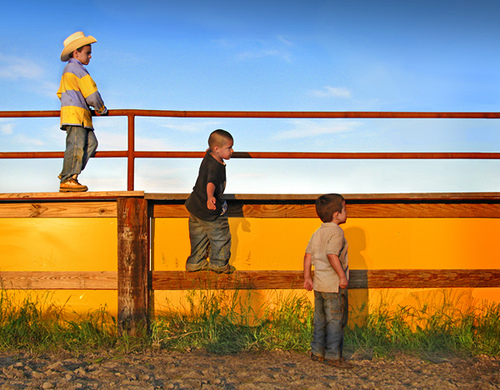

Caption:A man in a unk .


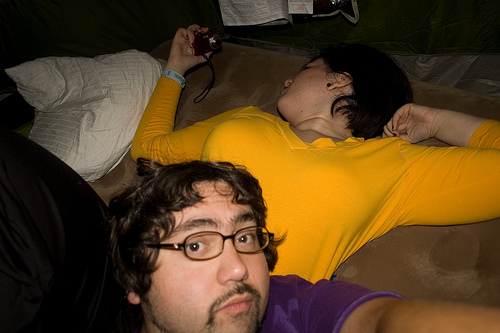

Caption:A man in a unk .


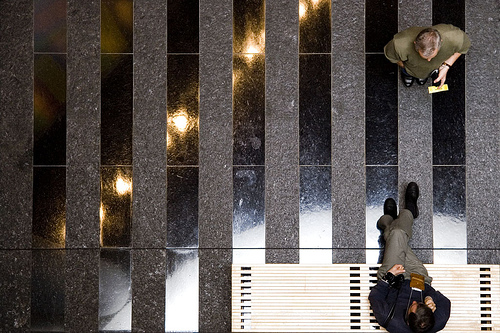

Caption:A man in a unk .


In [ ]:
sample = np.random.choice(preds, 3)
for samp in sample:
    display(samp['image_id'])
    print("Caption:" + samp['caption'])